# Выращиваем решающее дерево своими руками

### OzonMasters, "Машинное обучение 1"

В этом ноутбуке вам предлагается реализовать решающее дерево.

## Введение

Для начала импортируем библиотеки, которые нам понадобятся в дальнейшем:

In [54]:
import numpy as np

from sklearn.metrics import accuracy_score
import collections 

### Решающее дерево

Вспомним, что такое решающее дерево.

Решающее дерево - алгоритм машинного обучения, задающийся специальным графом-деревом. В данном задании мы будем использовать бинарное дерево. Каждая внутренняя вершина такого дерева соответствует функции предикату $\mathbb{I}[x_{\alpha} \geq \beta]$. Каждая листовая вершина соответствует некоторому значению ответа, которое будет выдавать алгоритм (вещественное число в случае регрессии, номер класса или вектор вероятностей в случае классификации).

На этапе обучения нам необходимо построить само дерево, а также выбрать $\alpha$ и $\beta$ для каждой внутренней вершины и метку прогноза для каждой листовой вершины. Задача построения "наилучшего" дерева (например того, которое не совершает ошибок и имеет минимальное число вершин) является NP-полной, поэтому при построении деревьев на практике приходиться использовать жадные алгоритмы.

На этапе применения все объекты пропускаются через дерево. Изначально, для каждого объекта вычисляется значение функции-предиката корневой вершины. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую. Затем вычисляется значение предиката в новой вершине и делается переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина. Алгоритм возвращает то значение, которое будет приписано этой вершине.

### Выбор $\alpha$ и $\beta$

На этапе построения дерева мы будем выбирать предикаты для каждой новой вершины, максимизируя функционал качества для разбиения вершины на два поддерева, который можно записать в следующем виде:
$$ Q(R, \alpha, \beta) = H(R) - \frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r) $$

* $H$ - критерий информативности
* $R$ - объекты в текущей вершине
* $R_r$ - объекты, попадающие в правое поддерево
* $R_l$ - объекты, попадающие в левое поддерево

Например, критерий информативности Джини для задачи классификации:

$$ H(R) = \sum_{k=1}^K p_k (1 - p_k) = 1 - \sum_{k=1}^K p_k^2 $$

* $p_k$ - доля объектов с классом $k$ среди $R$
* $K$ - общее число классов

При разбиении вершины на два поддерева мы хотим максимизировать функционал качества, оптимизируя:

* $\alpha$ - номер признака в предикате
* $\beta$ - пороговое значение предиката

В данном задании оптимизацию мы будем проводить, используя полный перебор значений. Для $\alpha$ множество перебираемых значений - все имеющиеся признаки, для $\beta$ - все встречающиеся в обучающей выборке значения каждого признака, кроме наименьшего и наибольшего.

## 1. Построение критерия и вычисление предиката

В данном пункте предлагается:
- реализовать метод `get_best_split` у абстрактного класса `Criterion`, который выполняет поиск порога разбиения $\beta$ по вектору признаков;
- для каждого из критериев `GiniCriterion`, `EntropyCriterion`, `MSECriterion` реализовать два метода:
    - `score`, считает чистоту узла, т.е. непосредственно сам критерий $H(R)$;
    - `get_predict_val`, вычисляет предсказанное значение в листе.

In [55]:
class Criterion:
    def get_best_split(self, feature, target):
        """
        Parameters
        ----------
        feature : feature vector, np.ndarray.shape = (n_samples, )
        target  : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        threshold : value to split feature vector, float
        q_value   : impurity improvement, float
        """
        
        #splits = (np.roll(feature, -1)[:-1] - feature[:-1])/2
        #splits = feature[:-1]+splits
        #best_Q = -float('inf')
        #best_threshold = None
        #for s in splits:
        #    mask = feature >= s
        #    Q = self.score(target) \
        #        - mask.sum()*self.score(target[mask])/target.shape[0] \
        #        - (~mask).sum()*self.score(target[~mask])/target.shape[0] 
        #    if Q > best_Q:
        #        best_Q = Q
        #        best_threshold = s
        #   
        #return best_threshold, best_Q
    
        indices = feature.argsort()
        target_srt = target[indices]
        N = len(target)
        
        q_best = -np.inf
        i_best = None
        
        h_0 = self.score(target)
        
        for i in range(1, N):
            h_l = self.score(target_srt[:i])
            h_r = self.score(target_srt[i:])

            q = h_0 - i / N * h_l - (N - i) / N * h_r
            if q > q_best:
                q_best = q
                i_best = i
        threshold = (feature[indices[i_best]] + feature[indices[i_best - 1]]) / 2
        return threshold, q_best
    
    def score(self, target):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        impurity : float
        """
        
        raise NotImplementedError("Put your code here")

    def get_predict_val(self, target : np.ndarray):
        """
        Parameters
        ----------
        target : target vector, np.ndarray.shape = (n_samples, )

        Returns
        -------
        prediction :
            - classification: prob ability distribution in node, np.ndarray.shape = (n_classes, )
            - regression: best constant approximation, float
        """

        raise NotImplementedError


class GiniCriterion(Criterion):
    def __init__(self, n_classes):
        self.n_classes = n_classes
    
    def get_predict_val(self, classes : np.ndarray):
        p = np.bincount(classes, minlength=self.n_classes)/len(classes)
        return p
    
    def score(self, classes):
        pred = self.get_predict_val(classes)
        return 1 - (pred ** 2).sum()

class EntropyCriterion(Criterion):
    EPS = 1e-6
    
    def __init__(self, n_classes):
        self.n_classes = n_classes

    def get_predict_val(self, classes):
        p = np.bincount(classes, minlength=self.n_classes)/len(classes)
        return p
    
    def score(self, classes):
        pred = self.get_predict_val(classes)
        return np.sum(pred * -np.log(pred + self.EPS))


class MSECriterion(Criterion):
    def get_predict_val(self, target):
        return np.mean(target)
        
    def score(self, target):
        target_mean = np.mean(target)
        ans = np.mean(np.square(target - target_mean))
        return ans

Проверь себя:

In [56]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
y_true = [0.2, 0.3, 0.3, 0, 0.2]
y_pred = GiniCriterion(n_classes=5).get_predict_val(target)
assert np.allclose(y_pred, y_true)

In [57]:
target = [1, 1, 2, 4, 2, 2, 0, 1, 0, 4]
scores = GiniCriterion(n_classes=5).score(target)
assert np.isclose(scores, 0.74)

In [58]:
N = 100

x = np.arange(N)
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

threshold, q_best = GiniCriterion(n_classes=2).get_best_split(x, y)
assert np.isclose(threshold, 49.5)
assert np.isclose(q_best, 0.5)

## 2. Вычисление параметров предиката и разбиение вершины дерева

Ниже вам предлагается реализовать несколько методов. Для класса `TreeNode` необходимо реализовать методы:
* `get_best_split` - вычисление оптимальных $\alpha$, $\beta$ для выбранного функционалиа $Q(R, \alpha, \beta)$;
* `split` – разбиение узла с заданными подобранными параметрами.

In [59]:
class TreeNode:
    def __init__(self, impurity, predict_val, depth):
        self.impurity = impurity        # node impurity
        self.predict_val = predict_val  # prediction of node
        self.depth = depth              # current node depth
        
        self.feature = None             # feature to split
        self.threshold = None           # threshold to split
        self.improvement = -np.inf      # node impurity improvement after split
        
        self.child_left = None
        self.child_right = None
    
    @property
    def is_terminal(self):
        return self.child_left is None and self.child_right is None
    
    @classmethod
    def get_best_split(cls, X, y, criterion):
        '''
        Finds best split for current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        
        Returns
        -------
        feature   : best feature to split,  int
        threshold : value to split feature, float
        q_value   : impurity improvement,   float
        '''
        
        q_best = -np.inf
        t_best = None
        f_best = None
        
        # перемешать фичи
        for fi in range(X.shape[1]):
            t, q = criterion.get_best_split(X[:, fi], y)
            if q > q_best:
                q_best = q
                t_best = t
                f_best = fi
        
        return f_best, t_best, q_best
        
    def get_best_split_mask(self, X):
        '''
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
        '''

        return X[:, self.feature] >= self.threshold
    
    def split(self, X, y, criterion, **split_params):
        '''
        Split current node
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        split_params : result of get_best_split method
        
        Returns
        -------
        right_mask : indicates samples in right node after split
            np.ndarray.shape = (n_samples, )
            np.ndarray.dtype = bool
            
        child_left  : TreeNode
        child_right : TreeNode
        '''
        
        self.feature = split_params['feature']
        self.threshold = split_params['threshold']          
        self.improvement = split_params['improvement']
        
        mask_right_child = self.get_best_split_mask(X)
        self.child_left = self.from_criterion(y[~mask_right_child], criterion, self.depth + 1)
        self.child_right = self.from_criterion(y[mask_right_child], criterion, self.depth + 1)

        return mask_right_child, self.child_left, self.child_right
    @classmethod
    def from_criterion(cls, y, criterion, depth=0):
        return cls(
            impurity=criterion.score(y),
            predict_val=criterion.get_predict_val(y),
            depth=depth,
        )

Проверьте себя:

In [60]:
N, M = 100, 10
f = 3

criterion = GiniCriterion(n_classes=2)
x = np.c_[[np.arange(N) if f == fi else np.random.random(size=N) for fi in range(M)]].T
y = np.r_[np.ones(N // 2), np.zeros(N - N // 2)].astype(int)

In [61]:
best_feature, best_threshold, improvement = TreeNode.get_best_split(x, y, criterion)

assert best_feature == f
assert best_threshold == 49.5
assert improvement == 0.5

## 3. Реализация дерева.

Вот мы и добрались до самого важного. В классе `DecisionTree` вам необходимо реализовать следующие методы:
* fit - обучения дерева
* predict - выдача предсказаний по дереву

Дерево предлагается строить самым простым способом – рекурсивно. Для реализации предлагается использовать два вспомогательных метода: 
* `_build_nodes` - вспомогательный рекурсивный метод для fit, разделяет вершину на две, если не выполняются условия останова;
* `_get_nodes_predictions` - вспомогательный рекурсивный метод для predict, пропускает объекты через вершины и заполняет матрицу предсказаний.

Важный вопрос при реализации: как выбрать критерий останова создания новой вершины?

Вершина не будет разветвляться, если выполнено хотя бы одно из четырех условий:
* если вершина на глубине `max_depth`;
* если в вершине меньше, чем `min_leaf_size` объектов;
* если в вершине все объекты имеют одинаковые метки;
* если функционал качества не увеличивается больше, чем на `min_improvement`.

Также для интерпретации важности признаков, участвующих в построении дерева, предлагается реализовать метод-свойство `feature_importances_`.

In [62]:
from collections import deque


class DecisionTree:
    def __init__(self, max_depth=None, min_leaf_size=1, min_improvement=None):
        self.criterion = None
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.min_improvement = min_improvement

    def _build_nodes(self, X, y, criterion, indices, node):
        '''
        Builds tree recursively
        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        y : target values, np.ndarray.shape = (n_samples, )
        criterion : criterion to split by, Criterion
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''
        
       
        if self.max_depth is not None and node.depth >= self.max_depth:
            return None
        
        if self.min_leaf_size is not None and self.min_leaf_size > len(indices) :
            return None
        
        if np.unique(y[indices]).shape[0] <= 1:
            return None
        
        
        
        
        X_node, y_node = X[indices], y[indices]
        feature, threshold, improvement = node.get_best_split(X_node, y_node, criterion)
        
        if np.all(np.array(X_node[:, feature]) >= threshold) or np.all(np.array(X_node[:, feature]) < threshold):
            return

        if self.min_improvement is not None and improvement < self.min_improvement:
            return None
        
        
        mask_right, child_left, child_right = node.split(
            X_node, y_node, criterion,
            feature=feature,
            threshold=threshold,
            improvement=improvement)
        
        
        
        self._build_nodes(X,y,criterion,indices[~mask_right], child_left)
        self._build_nodes(X,y,criterion,indices[mask_right], child_right)

        
    def _get_nodes_predictions(self, X, predictions, indices, node):
        '''        
        Parameters
        ----------
        X : samples in node, np.ndarray.shape = (n_samples, n_features)
        predictions : result matrix to be feild,
            - classification : np.ndarray.shape = (n_samples, n_classes)
            - regression : np.ndarray.shape = (n_samples, )
        indices : samples' indices in node,
            np.ndarray.shape = (n_samples, )
            nd.ndarray.dtype = int
        node : current node to split, TreeNode
        '''
                
        if node.is_terminal:
            predictions[indices] = node.predict_val 
        else:
            mask = node.get_best_split_mask(X[indices])
            indices_r = indices[mask]
            indices_l = indices[~mask]
            
            self._get_nodes_predictions(X, predictions, indices[mask] , node.child_right )
            self._get_nodes_predictions(X, predictions, indices[~mask] , node.child_left )
            
            
    
    @property
    def feature_importances_(self):
        '''
        Returns
        -------
        importance : cummulative improvement per feature, np.ndarray.shape = (n_features, )
        '''
        importance = np.zeros(self.n_features_)
        
        queue = deque()
        queue.append(self.root_)
        
        while len(queue):
            node = queue.popleft()
            if node.is_terminal:
                continue
            importance[node.feature] += node.improvement
            queue.append(node.child_left)
            queue.append(node.child_left)
        return importance

А теперь на основе реализованного в общем виде дерева, сделаем дерево для классификации:

In [63]:
class ClassificationDecisionTree(DecisionTree):
    def __init__(self, criterion='gini', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('gini', 'entropy', ):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_classes_ = np.max(y) + 1
        self.n_features_ = X.shape[1]
        
        if self.criterion == 'gini':
            criterion = GiniCriterion(n_classes=self.n_classes_)
        elif self.criterion == 'entropy':
            criterion = EntropyCriterion(n_classes=self.n_classes_)
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        probas = np.zeros(shape=(X.shape[0], self.n_classes_))
        self._get_nodes_predictions(X, probas, np.arange(X.shape[0]), self.root_)
        return probas

Проверь себя:

In [64]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [65]:
some_X.shape, some_y.shape

((400, 2), (400,))

In [66]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

In [67]:
assert (some_tree.feature_importances_ == [0.25, 1.  ]).all()

Ещё одна проверка:

In [68]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_X = np.hstack((some_X, np.random.random((400, 100))))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [69]:
assert isinstance(predictions, type(np.zeros(0)))
assert (predictions == some_y).all()

## 4. Визуализация результатов

Давайте проверим, что дерево работает на нескольких модельных задачах.

In [70]:
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
%matplotlib inline

Функция для визуализации двумерной выборки:

In [71]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

Функция для визуализации работы дерева на двумерной выборке:

In [72]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

Для начала рассмотрим простую задачу с полностью разделимыми по некоторому признаку классами:

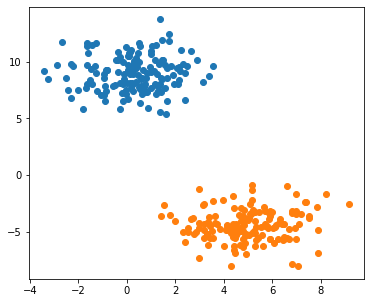

In [73]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)

plot_data(X, y)

Применим к этой задаче алгоритм "решающий пень":

In [74]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

Если вы всё реализовали правильно, то должно получиться что-то такое:

Accuracy = 1.0


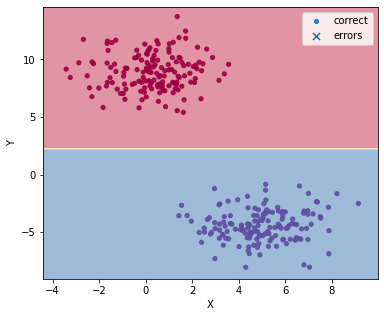

In [75]:
plot_decision_surface(some_tree, X, y)

Теперь рассмотрим более сложную задачу с плохо разделимыми классами:

In [76]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

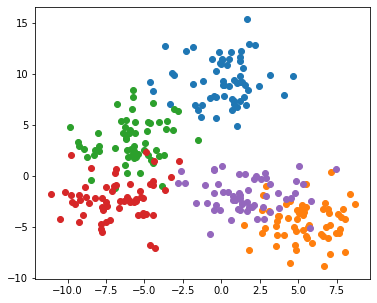

In [77]:
plot_data(X, y)

Посмотрим на результаты, которые получаются при разных значениях глубины:

Accuracy = 0.4


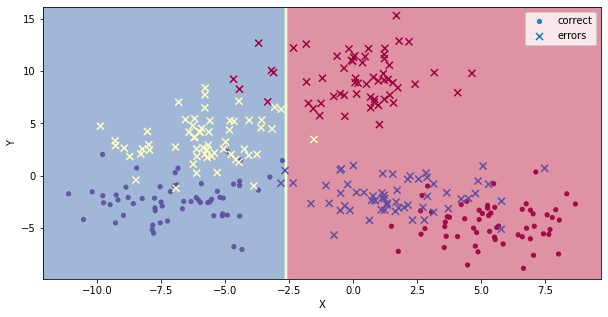

In [78]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.7466666666666667


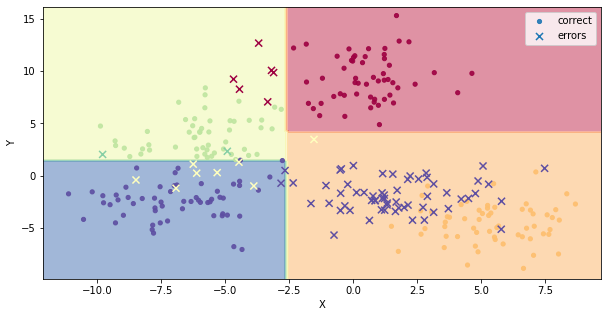

In [79]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.89


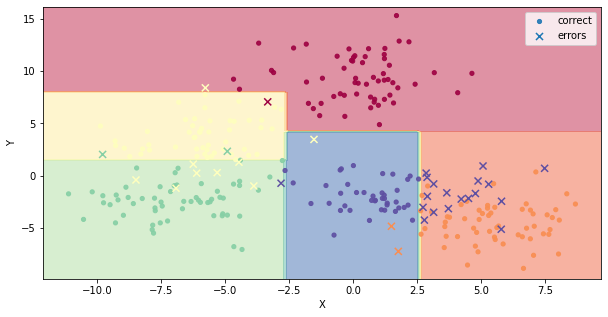

In [80]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.94


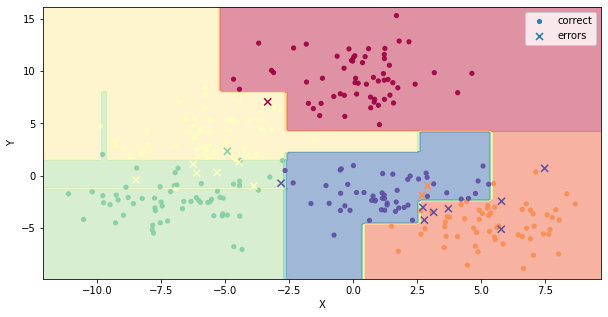

In [81]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 1.0


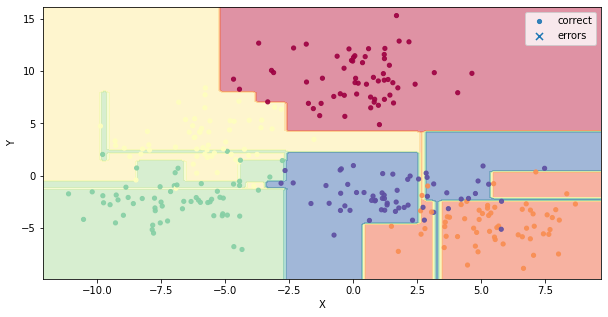

In [82]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Можно заметить, что начиная с некоторого значения глубины, дерево начинает сильно переобучаться (новые сплиты пытаются описать максимум 1-2 объекта). Это можно поправить, изменяя параметр `min_leaf_size` или `min_improvement`.

Accuracy = 0.9266666666666666


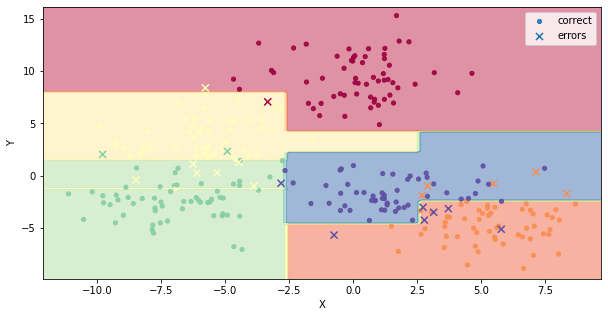

In [83]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=20)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.92


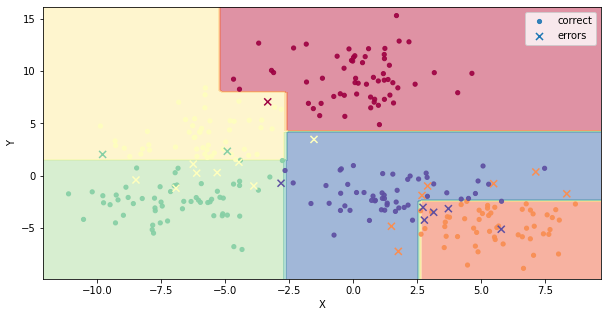

In [84]:
some_tree = ClassificationDecisionTree(max_depth=10, min_improvement=0.08)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

## Домашнее задание (10 баллов)

1. (4 балла) Доделать все пункты ноутбука до конца

2. (2 балла) Для регрессионного дерева необходимо использовать такой критерий:
    $$H(R) = \min_c \frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i - c)^2$$
    
    Докажите, что минимум H(R) достигается при $c$:

    $$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

3. (2 балла) Реализуйте регрессионное дерево. В качестве критерия необходимо использовать критерий, определённый в пункте 2. В качестве функции выдачи результатов необходимо использовать среднее значение ответов по всем объектам в листе.

    Сгенерируйте однопризнаковую выборку для тестирования дерева и покажите работу дерева на этой выборке. Отобразите на одном графике значения алгоритма и точки. Нарисуйте эту картинку для нескольких значений глубины. Сделайте выводы.
    
    
3. (2 балла) Протестируйте ваше дерево на california_housing датасете (можно загрузить с помощью sklearn.datasets.fetch_california_housing).
    Разбейте данные на обучение, контроль и тест. Подберите гиперпараметры по контрольной выборке, покажите качество алгоритма на тестовой. Сделайте выводы.


Бонусных баллов в этот раз нет :)

Мы минимизируем функцию $H(R)$ по $c$ , такая функция будет действовать из $R$ в $R^+$, следовательно надо просто взять производную по $с$, но сначала расскроем квадрат внутри суммы, получим:

$$\frac{1}{|R|} \sum_{(x_i, y_i) \in R} (y_i^2 -2y_ic+c^2)$$

Берем производную по $c$, получаем :

$$\frac{1}{|R|} \sum_{(x_i, y_i) \in R} ( -2y_i+2c) $$

приравнием к нулю

$$\frac{1}{|R|} \sum_{(x_i, y_i) \in R} ( -y_i+c) = 0 $$

разбиваем суммы

$$\frac{1}{|R|} \sum_{(x_i, y_i) \in R} -y_i + \frac{|R|}{|R|}c = 0 $$

в итоге получаем

$$ c = \frac{1}{|R|} \sum_{(x_j, y_j) \in R} y_j$$

In [85]:
class RegressionTree(DecisionTree):
    def __init__(self, criterion='MSE', **kwargs):
        super().__init__(**kwargs)
        
        if criterion not in ('MSE'):
            raise ValueError('Unsupported criterion', criterion)
        self.criterion = criterion
            
    def fit(self, X, y):
        self.n_features_ = X.shape[1]
        
        if self.criterion == 'MSE':
            criterion = MSECriterion()
        else:
            raise ValueError('Unsupported criterion', criterion)

        self.root_ = TreeNode.from_criterion(y, criterion)
        self._build_nodes(X, y, criterion, np.arange(X.shape[0]), self.root_)

        return self
    
    def predict(self, X):
        pred = np.zeros(shape=(X.shape[0]))
        self._get_nodes_predictions(X, pred, np.arange(X.shape[0]), self.root_)
        return pred

https://www.programcreek.com/python/example/104698/sklearn.datasets.make_regression

In [86]:
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
def make_regression_df(n_samples: int=100, n_num_features: int=1, random_state: int=0):
    np.random.seed(random_state)
    X, y = make_regression(n_samples=n_samples, n_features=n_num_features,
                           random_state=random_state, noise = 5)
    return X, y 
def plot_regr(model, X, y_true):
    
    plt.figure(figsize=(10,10))
    t = np.arange(-3,3,0.1).reshape(60,1)
    y = model.predict(t)
    plt.plot(t,y,color='red')
    plt.scatter(X,y_true)
    plt.legend(('model_pred','y_true'));
    
    y_pred = model.predict(X)
    print("MSE =", mean_squared_error(y_true, y_pred))

In [87]:
X, y = make_regression_df(n_samples=100)

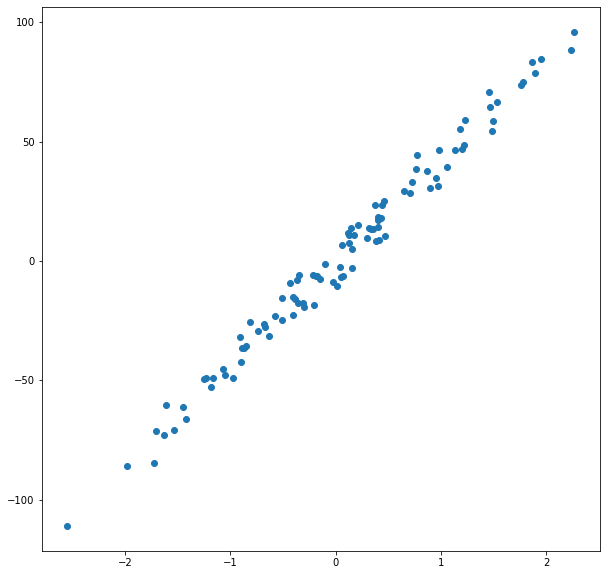

In [88]:
plt.figure(figsize=(10,10))
plt.scatter(X,y);

MSE = 671.1416181052243


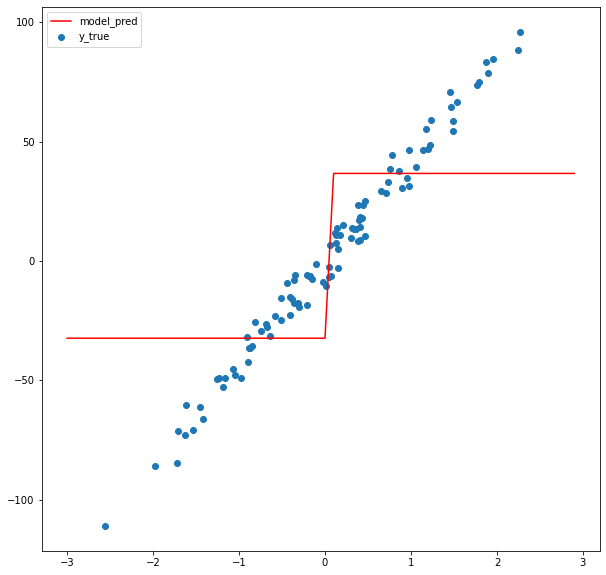

In [89]:
model = RegressionTree(max_depth=1, min_leaf_size=1)
model.fit(X,y)

plot_regr(model, X, y)

MSE = 185.55227015529803


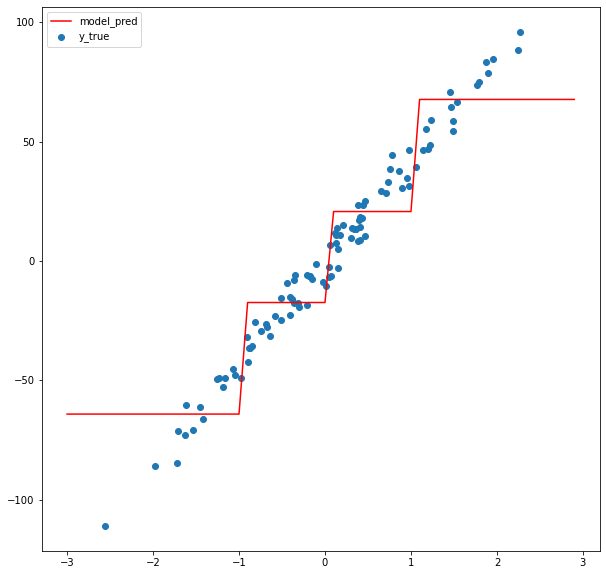

In [90]:
model = RegressionTree(max_depth=2, min_leaf_size=1)
model.fit(X,y)

plot_regr(model, X, y)

MSE = 53.79762128176871


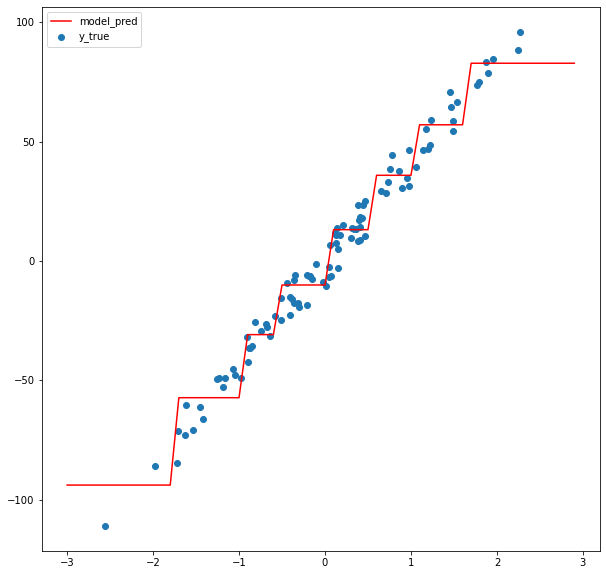

In [91]:
model = RegressionTree(max_depth=3, min_leaf_size=1)
model.fit(X,y)

plot_regr(model, X, y)

MSE = 14.299459423433436


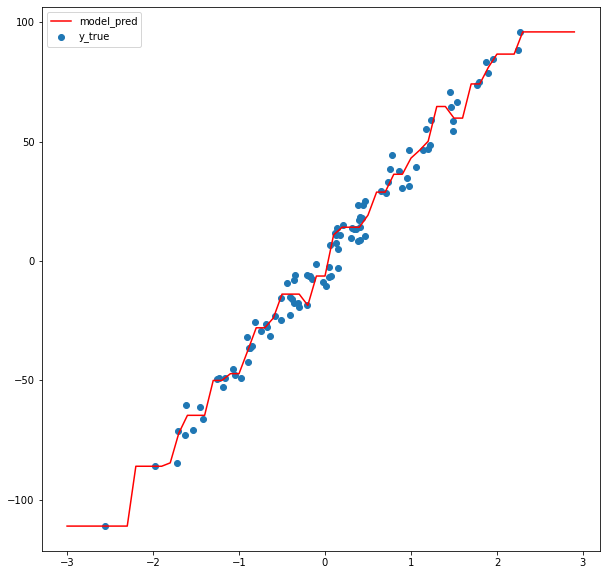

In [92]:
model = RegressionTree(max_depth=5, min_leaf_size=1)
model.fit(X,y)

plot_regr(model, X, y)

MSE = 0.8179831916119805


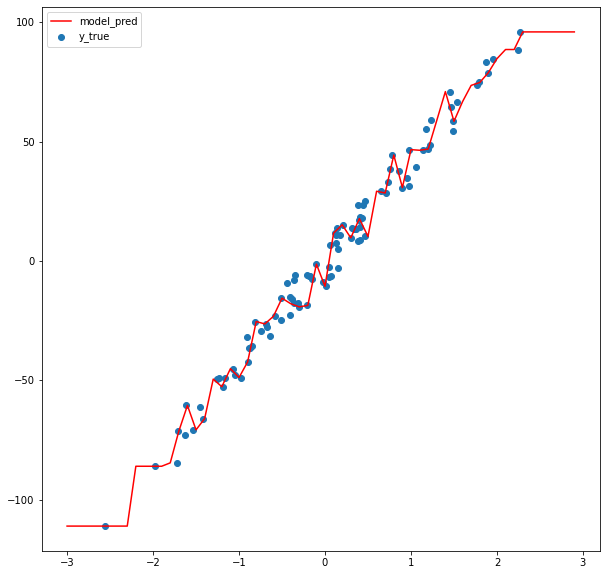

In [93]:
model = RegressionTree(max_depth=10, min_leaf_size=1)
model.fit(X,y)

plot_regr(model, X, y)

При увеличении глубины видно как дерево переобучается, сильно затачиваясь на данные из трейна

Теперь посмотрим как ведет себя алгоритм при разных параметрах min_leaf_size и depth

In [94]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [95]:
data = fetch_california_housing()

In [96]:
X = data['data']
y = data['target']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [98]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [99]:
depths = [5,10,20,40,80,160]
leaf_sizes = [5,10,20,40,80]
best = {'max_depth' : [],'min_leaf_size' : [], 'MSE' : []}
for d in depths:
    for l in leaf_sizes:
        print('d={}  l={}'.format(d,l))
            
        model = RegressionTree(max_depth=d, min_leaf_size=l)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_pred, y_val)
        best['max_depth'].append(d)
        best['min_leaf_size'].append(l)
        best['MSE'].append(mse)


d=5  l=5
d=5  l=10
d=5  l=20
d=5  l=40
d=5  l=80
d=10  l=5
d=10  l=10
d=10  l=20
d=10  l=40
d=10  l=80
d=20  l=5
d=20  l=10
d=20  l=20
d=20  l=40
d=20  l=80
d=40  l=5
d=40  l=10
d=40  l=20
d=40  l=40
d=40  l=80
d=80  l=5
d=80  l=10
d=80  l=20
d=80  l=40
d=80  l=80
d=160  l=5
d=160  l=10
d=160  l=20
d=160  l=40
d=160  l=80


In [100]:
info = pd.DataFrame.from_dict(best)

Text(0.5, 1.0, 'MSE')

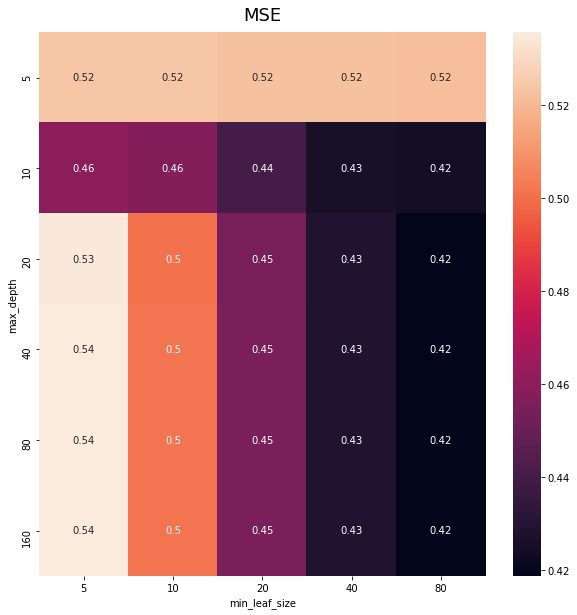

In [101]:
info = pd.DataFrame.from_dict(best)
info = info.pivot(index='max_depth', columns='min_leaf_size', values='MSE')
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(info, annot=True)
heatmap.set_title('MSE', fontdict={'fontsize':18}, pad=12)

При увеличении глубины и увеличения колличества обьектов в листе ошибка уменьшается. При маленькой глубине колличество обьектов в листе вообще не влият на функционал ошибки. Также при 80 обьектах в листе можно уменьшить глубину дерева без потери качества на валидации, что может ускорить время обучения.

Теперь переберем по сетке все три параметра дерева

In [102]:
depths = [5,10,20,40,80,160]
leaf_sizes = [5,10,20,40,80]
min_improvements = [0.05, 0.1,0.5, 1]
mse_best = +np.inf
params = None
for d in depths:
    for m in min_improvements:
        for l in leaf_sizes:
            print('d={}  l={} m={}'.format(d,l,m))
            model = RegressionTree(max_depth=d, min_leaf_size=l, min_improvement=m)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_pred, y_val)
            if mse < mse_best:
                params = d,l,m
                mse_best = mse

d=5  l=5 m=0.05
d=5  l=10 m=0.05
d=5  l=20 m=0.05
d=5  l=40 m=0.05
d=5  l=80 m=0.05
d=5  l=5 m=0.1
d=5  l=10 m=0.1
d=5  l=20 m=0.1
d=5  l=40 m=0.1
d=5  l=80 m=0.1
d=5  l=5 m=0.5
d=5  l=10 m=0.5
d=5  l=20 m=0.5
d=5  l=40 m=0.5
d=5  l=80 m=0.5
d=5  l=5 m=1
d=5  l=10 m=1
d=5  l=20 m=1
d=5  l=40 m=1
d=5  l=80 m=1
d=10  l=5 m=0.05
d=10  l=10 m=0.05
d=10  l=20 m=0.05
d=10  l=40 m=0.05
d=10  l=80 m=0.05
d=10  l=5 m=0.1
d=10  l=10 m=0.1
d=10  l=20 m=0.1
d=10  l=40 m=0.1
d=10  l=80 m=0.1
d=10  l=5 m=0.5
d=10  l=10 m=0.5
d=10  l=20 m=0.5
d=10  l=40 m=0.5
d=10  l=80 m=0.5
d=10  l=5 m=1
d=10  l=10 m=1
d=10  l=20 m=1
d=10  l=40 m=1
d=10  l=80 m=1
d=20  l=5 m=0.05
d=20  l=10 m=0.05
d=20  l=20 m=0.05
d=20  l=40 m=0.05
d=20  l=80 m=0.05
d=20  l=5 m=0.1
d=20  l=10 m=0.1
d=20  l=20 m=0.1
d=20  l=40 m=0.1
d=20  l=80 m=0.1
d=20  l=5 m=0.5
d=20  l=10 m=0.5
d=20  l=20 m=0.5
d=20  l=40 m=0.5
d=20  l=80 m=0.5
d=20  l=5 m=1
d=20  l=10 m=1
d=20  l=20 m=1
d=20  l=40 m=1
d=20  l=80 m=1
d=40  l=5 m=0.05
d=40  l=10

In [103]:
mse_best

0.5230994760717016

In [104]:
params

(20, 80, 0.05)

Лучшая комбинация в итоге: 
depth = 20
min_leaf_size = 80


ограничение на улучшение использовать не будем.

In [107]:
model = RegressionTree(max_depth=20, min_leaf_size=80)
model.fit(X_train, y_train)
mean_squared_error(model.predict(X_val), y_val)

0.41875459765857914

In [108]:
y_pred = model.predict(X_test)
mean_squared_error(y_pred, y_test)

0.41831270625985695